# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '04'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

fname1=mdir+edir+'icebox_train_rc.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 1956367)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 22:04:39 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_ice.values
    n_s  = xr.open_dataset(fname).n_ice.values
    # reflectivity
    z_s  = xr.open_dataset(fname).z_ice.values
    # some numerical lower bounds
    q_min = 1e-20
    n_min = 1e-20
    z_min = 1e-20
    p_min = 1e-20
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    z_s = np.log(z_s, where=z_s>q_min, out=np.nan*n_s)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ z_s, q_s, n_s, temp, rho ]))
    dataset = dataset.T
    dataset.columns = [ 'z_s', 'q_s', 'n_s', 'temp', 'rho' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

In [8]:
df.describe()

z_s           q_s           n_s          temp           rho
count  1.643749e+06  1.643749e+06  1.643749e+06  1.643749e+06  1.643749e+06
mean  -3.202404e+01 -9.570136e+00  1.346232e+01  2.408937e+02  6.824716e-01
std    3.255192e+00  3.351762e+00  4.028980e+00  1.322142e+01  1.627547e-01
min   -4.605160e+01 -2.658209e+01 -7.609862e+00  2.066400e+02  4.120000e-01
25%   -3.241794e+01 -9.779572e+00  1.197041e+01  2.312800e+02  5.600000e-01
50%   -3.107213e+01 -8.678889e+00  1.419319e+01  2.406100e+02  6.630000e-01
75%   -3.023890e+01 -7.711298e+00  1.620601e+01  2.491600e+02  7.700000e-01
max   -2.575177e+01 -4.316089e+00  2.052182e+01  2.738200e+02  1.289000e+00

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

z_s       q_s        n_s        temp    rho
0 -28.952803 -9.133379  11.592845  245.710007  0.697
2 -28.968716 -9.139882  11.587291  245.820007  0.698
5 -29.011213 -9.152449  11.577401  245.979996  0.700
6 -29.018637 -9.156137  11.574115  246.039993  0.701
7 -29.026598 -9.159457  11.570817  246.089996  0.702

In [11]:
dataset_train.describe()

z_s           q_s           n_s          temp           rho
count  1.152130e+06  1.152130e+06  1.152130e+06  1.152130e+06  1.152130e+06
mean  -3.202455e+01 -9.571088e+00  1.346079e+01  2.409014e+02  6.825597e-01
std    3.255682e+00  3.353320e+00  4.030661e+00  1.322462e+01  1.628426e-01
min   -4.605160e+01 -2.646009e+01 -7.609862e+00  2.066400e+02  4.120000e-01
25%   -3.241883e+01 -9.779890e+00  1.196908e+01  2.312800e+02  5.600000e-01
50%   -3.107185e+01 -8.679065e+00  1.419388e+01  2.406200e+02  6.630000e-01
75%   -3.023837e+01 -7.710405e+00  1.620526e+01  2.491600e+02  7.700000e-01
max   -2.575177e+01 -4.316089e+00  2.052182e+01  2.738200e+02  1.289000e+00

In [12]:
dataset_test.describe()

z_s            q_s            n_s           temp  \
count  246614.000000  246614.000000  246614.000000  246614.000000   
mean      -32.033527      -9.575246      13.462800     240.881073   
std         3.265313       3.359290       4.033050      13.235354   
min       -46.051502     -26.399336      -7.061793     206.740005   
25%       -32.425461      -9.784914      11.975244     231.242504   
50%       -31.077518      -8.681184      14.186522     240.589996   
75%       -30.243221      -7.716672      16.209579     249.190002   
max       -25.823307      -4.364108      20.520170     273.799988   

                 rho  
count  246614.000000  
mean        0.682379  
std         0.162793  
min         0.413000  
25%         0.559000  
50%         0.663000  
75%         0.770000  
max         1.286000

In [13]:
dataset_val.describe()

z_s            q_s            n_s           temp  \
count  245005.000000  245005.000000  245005.000000  245005.000000   
mean      -32.012184      -9.560511      13.469013     240.870270   
std         3.242633       3.336809       4.016972      13.192356   
min       -46.051601     -26.582088      -6.808362     207.160004   
25%       -32.404198      -9.774198      11.971236     231.300003   
50%       -31.068363      -8.676306      14.196683     240.570007   
75%       -30.237608      -7.709869      16.205740     249.119995   
max       -25.840696      -4.318714      20.520929     273.790009   

                 rho  
count  245005.000000  
mean        0.682148  
std         0.162303  
min         0.413000  
25%         0.560000  
50%         0.664000  
75%         0.769000  
max         1.283000

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
#    idx = dataset[ dataset['n_s'] < 0 ].index
#    dataset.drop(idx,inplace=True)   
#    idx = dataset[ dataset['z_s'] > -1 ].index
#    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

z_s           q_s           n_s          temp           rho
count  1.122035e+06  1.122035e+06  1.122035e+06  1.122035e+06  1.122035e+06
mean  -3.171071e+01 -9.239981e+00  1.381488e+01  2.402478e+02  6.737734e-01
std    2.655858e+00  2.701730e+00  3.424660e+00  1.273785e+01  1.548470e-01
min   -4.604136e+01 -1.999998e+01 -2.079442e+00  2.066400e+02  4.120000e-01
25%   -3.226213e+01 -9.611684e+00  1.217837e+01  2.309800e+02  5.570000e-01
50%   -3.102813e+01 -8.634120e+00  1.428732e+01  2.402100e+02  6.590000e-01
75%   -3.021309e+01 -7.678064e+00  1.626367e+01  2.483800e+02  7.590000e-01
max   -2.575177e+01 -4.316089e+00  2.052182e+01  2.738200e+02  1.289000e+00

In [17]:
dataset_test.describe()

z_s            q_s            n_s           temp  \
count  240143.000000  240143.000000  240143.000000  240143.000000   
mean      -31.717844      -9.242333      13.818611     240.227005   
std         2.662947       2.704486       3.424282      12.752283   
min       -45.986851     -19.998959      -2.079442     206.740005   
25%       -32.263687      -9.616341      12.181883     230.949997   
50%       -31.033459      -8.635189      14.282133     240.169998   
75%       -30.217880      -7.683665      16.267938     248.410004   
max       -25.823307      -4.364108      20.520170     273.799988   

                 rho  
count  240143.000000  
mean        0.673599  
std         0.154871  
min         0.413000  
25%         0.556000  
50%         0.658000  
75%         0.759000  
max         1.286000

### Pairplot

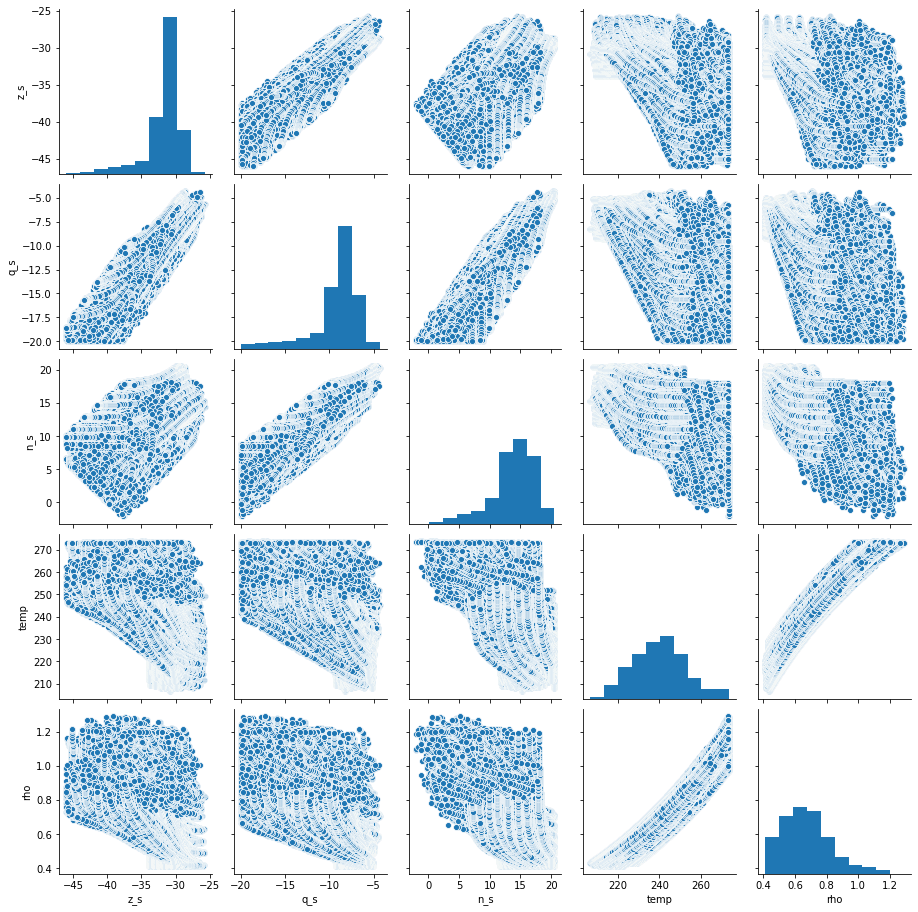

In [18]:
sns.pairplot(dataset_train[["z_s","q_s","n_s","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()
train_dataset5 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()
test_dataset5 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()
val_dataset5 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['temp','rho'], axis=1)
train_dataset2 = train_dataset2.drop(['temp'], axis=1)
#train_dataset3 = train_dataset3.drop(['ssi'], axis=1)
#train_dataset4 = train_dataset4.drop(['zi'], axis=1)
#train_dataset5 = train_dataset5.drop(['qs'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['temp','rho'], axis=1)
test_dataset2 = test_dataset2.drop(['temp'], axis=1)
#test_dataset3 = test_dataset3.drop(['ssi'], axis=1)
#test_dataset4 = test_dataset4.drop(['zi'], axis=1)
#test_dataset5 = test_dataset5.drop(['qs'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['temp','rho'], axis=1)
val_dataset2 = val_dataset2.drop(['temp'], axis=1)
#val_dataset3 = val_dataset3.drop(['ssi'], axis=1)
#val_dataset4 = val_dataset4.drop(['zi'], axis=1)
#val_dataset5 = val_dataset5.drop(['qs'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("z_s")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean      std        min        25%        50%  \
q_s  1122035.0  -9.239981  2.70173 -19.999977  -9.611684  -8.634120   
n_s  1122035.0  13.814881  3.42466  -2.079442  12.178368  14.287325   

           75%        max  
q_s  -7.678064  -4.316089  
n_s  16.263666  20.521822

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("z_s")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%  \
q_s  1122035.0  -9.239981  2.701730 -19.999977  -9.611684  -8.634120   
n_s  1122035.0  13.814881  3.424660  -2.079442  12.178368  14.287325   
rho  1122035.0   0.673773  0.154847   0.412000   0.557000   0.659000   

           75%        max  
q_s  -7.678064  -4.316089  
n_s  16.263666  20.521822  
rho   0.759000   1.289000

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("z_s")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean        std         min         25%         50%  \
q_s   1122035.0   -9.239981   2.701730  -19.999977   -9.611684   -8.634120   
n_s   1122035.0   13.814881   3.424660   -2.079442   12.178368   14.287325   
temp  1122035.0  240.247757  12.737845  206.639999  230.979996  240.210007   
rho   1122035.0    0.673773   0.154847    0.412000    0.557000    0.659000   

             75%         max  
q_s    -7.678064   -4.316089  
n_s    16.263666   20.521822  
temp  248.380005  273.820007  
rho     0.759000    1.289000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [28]:
# pop does not work for multiple columns, use copy instead

labels = [ 'z_s' ]

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [31]:
train_labels.describe()

z_s
count  1.122035e+06
mean  -3.171071e+01
std    2.655858e+00
min   -4.604136e+01
25%   -3.226213e+01
50%   -3.102813e+01
75%   -3.021309e+01
max   -2.575177e+01

In [32]:
train_dataset1.describe()

q_s           n_s
count  1.122035e+06  1.122035e+06
mean  -9.239981e+00  1.381488e+01
std    2.701730e+00  3.424660e+00
min   -1.999998e+01 -2.079442e+00
25%   -9.611684e+00  1.217837e+01
50%   -8.634120e+00  1.428732e+01
75%   -7.678064e+00  1.626367e+01
max   -4.316089e+00  2.052182e+01

In [33]:
train_dataset2.describe()

q_s           n_s           rho
count  1.122035e+06  1.122035e+06  1.122035e+06
mean  -9.239981e+00  1.381488e+01  6.737734e-01
std    2.701730e+00  3.424660e+00  1.548470e-01
min   -1.999998e+01 -2.079442e+00  4.120000e-01
25%   -9.611684e+00  1.217837e+01  5.570000e-01
50%   -8.634120e+00  1.428732e+01  6.590000e-01
75%   -7.678064e+00  1.626367e+01  7.590000e-01
max   -4.316089e+00  2.052182e+01  1.289000e+00

In [34]:
train_dataset3.describe()

q_s           n_s          temp           rho
count  1.122035e+06  1.122035e+06  1.122035e+06  1.122035e+06
mean  -9.239981e+00  1.381488e+01  2.402478e+02  6.737734e-01
std    2.701730e+00  3.424660e+00  1.273785e+01  1.548470e-01
min   -1.999998e+01 -2.079442e+00  2.066400e+02  4.120000e-01
25%   -9.611684e+00  1.217837e+01  2.309800e+02  5.570000e-01
50%   -8.634120e+00  1.428732e+01  2.402100e+02  6.590000e-01
75%   -7.678064e+00  1.626367e+01  2.483800e+02  7.590000e-01
max   -4.316089e+00  2.052182e+01  2.738200e+02  1.289000e+00

### Normalize the features

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [36]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s  1122035.0  4.753329e-07  1.0 -3.982633 -0.137580  0.224249  0.578117   
n_s  1122035.0  9.150870e-08  1.0 -4.641139 -0.477862  0.137953  0.715045   

          max  
q_s  1.822496  
n_s  1.958425

In [37]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_s  1122035.0  4.753329e-07  1.0 -3.982633 -0.137580  0.224249  0.578117   
n_s  1122035.0  9.150870e-08  1.0 -4.641139 -0.477862  0.137953  0.715045   
rho  1122035.0 -5.797170e-07  1.0 -1.690530 -0.754122 -0.095407  0.550392   

          max  
q_s  1.822496  
n_s  1.958425  
rho  3.973127

In [38]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_s   1122035.0  4.753329e-07  1.0 -3.982633 -0.137580  0.224249  0.578117   
n_s   1122035.0  9.150870e-08  1.0 -4.641139 -0.477862  0.137953  0.715045   
temp  1122035.0 -2.289116e-06  1.0 -2.638418 -0.727577 -0.002964  0.638432   
rho   1122035.0 -5.797170e-07  1.0 -1.690530 -0.754122 -0.095407  0.550392   

           max  
q_s   1.822496  
n_s   1.958425  
temp  2.635630  
rho   3.973127

### Normalize the labels

In [39]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%        50%  \
z_s  1122035.0 -31.710714  2.655858 -46.041355 -32.262135 -31.028128   

           75%       max  
z_s -30.213095 -25.75177

In [40]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [41]:
DNNstring='16x16x16'

def build_model_sigm(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [42]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(2,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [44]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.87078726],
       [-0.8707943 ],
       [-0.8708054 ],
       [-0.87080985],
       [-0.8708148 ],
       [-0.8708199 ],
       [-0.8708249 ],
       [-0.8708287 ],
       [-0.8708346 ],
       [-0.87083983]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [45]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [46]:
activ = "sigm"
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0309,  mae:0.1027,  mse:0.0309,  val_loss:0.0156,  val_mae:0.0824,  val_mse:0.0156,  
.....................................

Text(0, 0.5, 'MAE')

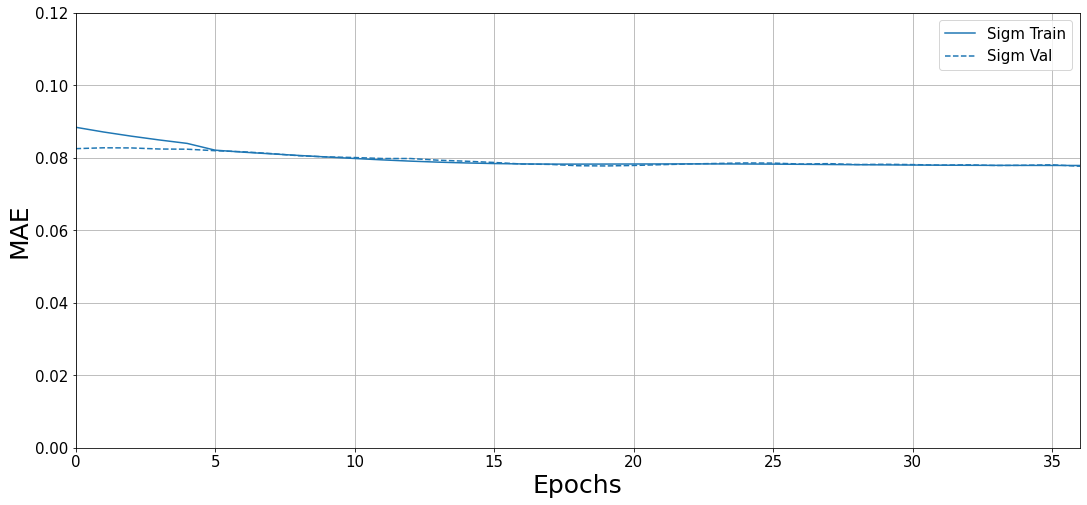

In [47]:
histories['sigm'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0,0.12])
plt.ylabel('MAE')

In [48]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0252,  mae:0.0841,  mse:0.0252,  val_loss:0.0093,  val_mae:0.0589,  val_mse:0.0093,  
....................

Text(0, 0.5, 'MAE')

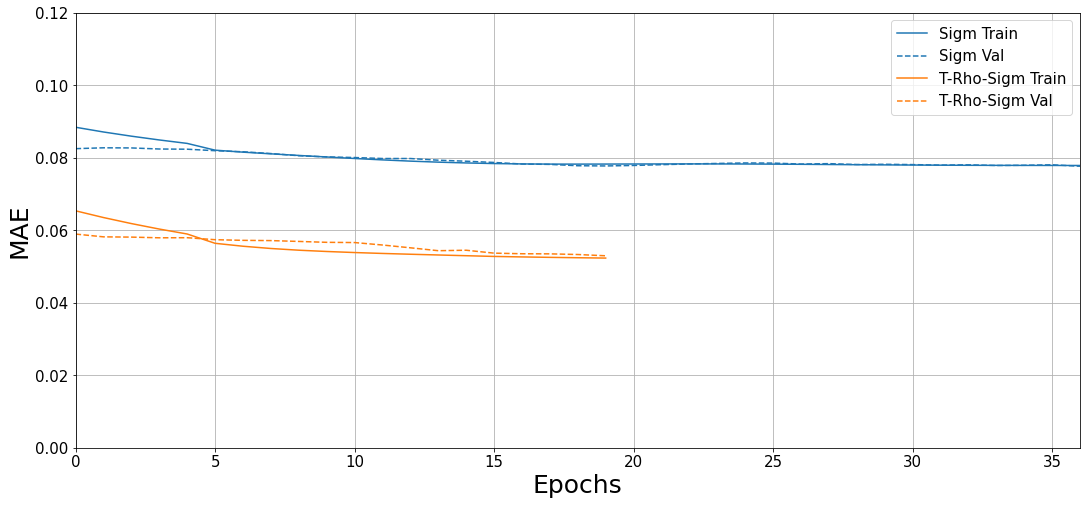

In [49]:
histories['T-rho-sigm'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.12])
plt.ylabel('MAE')

In [50]:
activ = "ReLU"
model4 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history4 = model4.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0164,  mae:0.0835,  mse:0.0164,  val_loss:0.0140,  val_mae:0.0761,  val_mse:0.0140,  
....................

Text(0, 0.5, 'MAE')

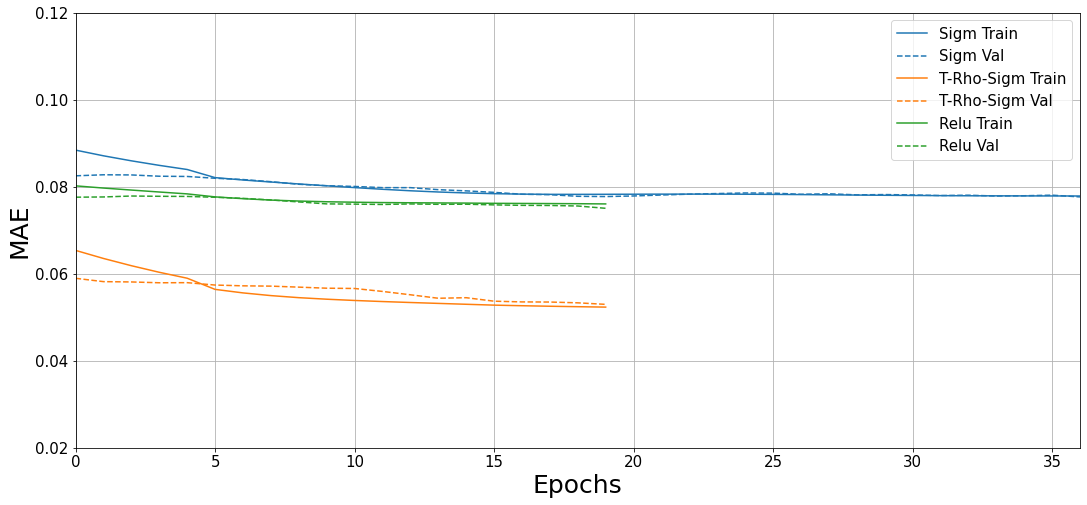

In [51]:
histories['ReLU'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.12])
plt.ylabel('MAE')

In [52]:
model5 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history5 = model5.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0125,  mae:0.0618,  mse:0.0125,  val_loss:0.0084,  val_mae:0.0507,  val_mse:0.0084,  
..................................

Text(0, 0.5, 'MAE')

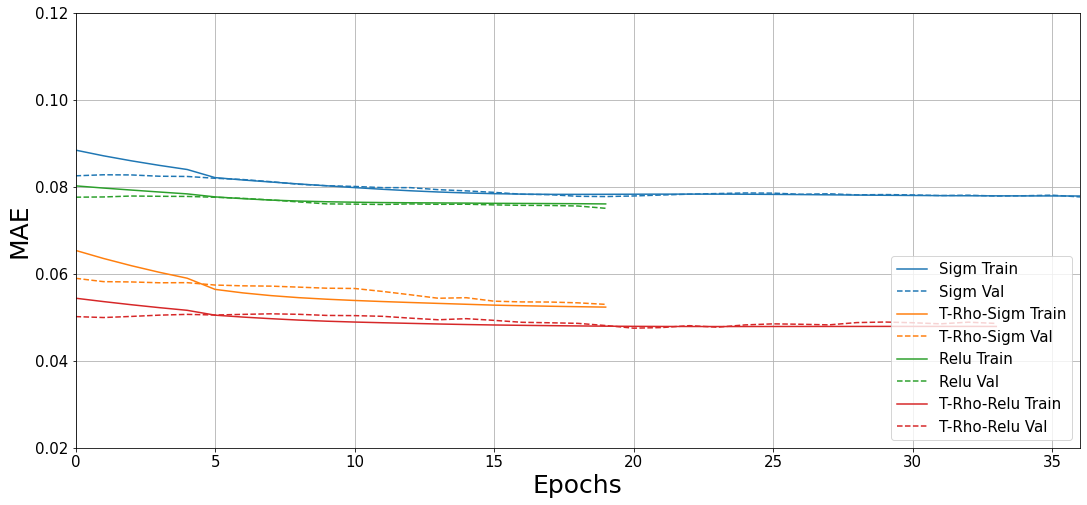

In [53]:
histories['T-rho-ReLU'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.12])
plt.ylabel('MAE')

In [54]:
activ = "ReLU_Adam"
model6 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history6 = model6.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0150,  mae:0.0815,  mse:0.0150,  val_loss:0.0143,  val_mae:0.0774,  val_mse:0.0143,  
...........................................

Text(0, 0.5, 'MAE')

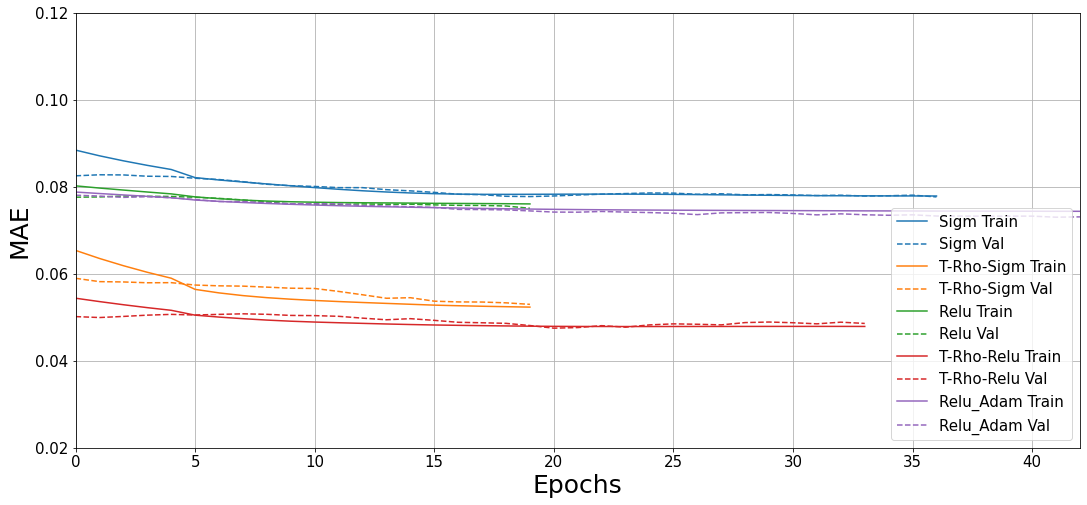

In [55]:
histories['ReLU_Adam'] = early_history6

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.12])
plt.ylabel('MAE')

In [56]:
model7 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history7 = model7.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0102,  mae:0.0579,  mse:0.0102,  val_loss:0.0086,  val_mae:0.0516,  val_mse:0.0086,  
...........................................

Text(0, 0.5, 'MAE')

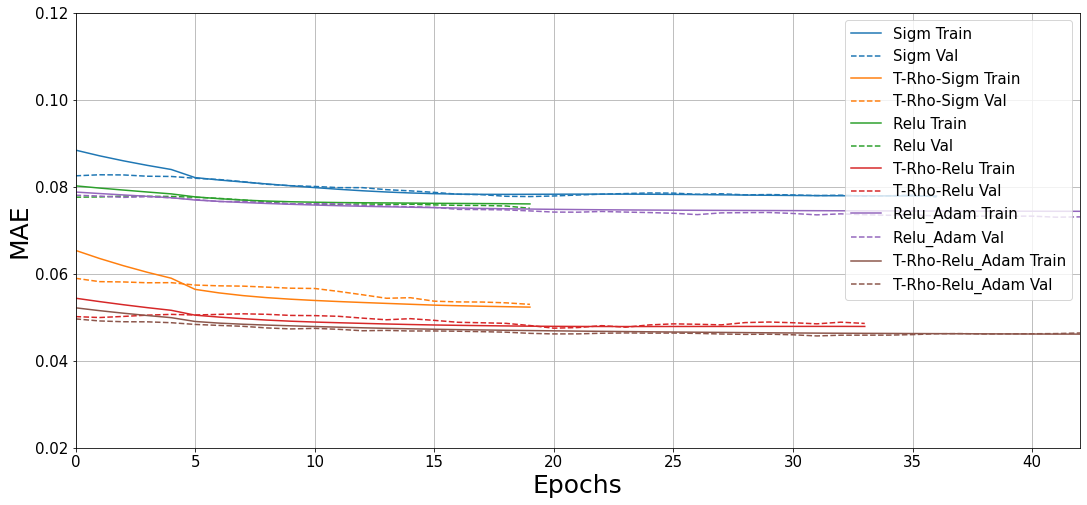

In [57]:
histories['T-rho-ReLU_Adam'] = early_history7

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.12])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

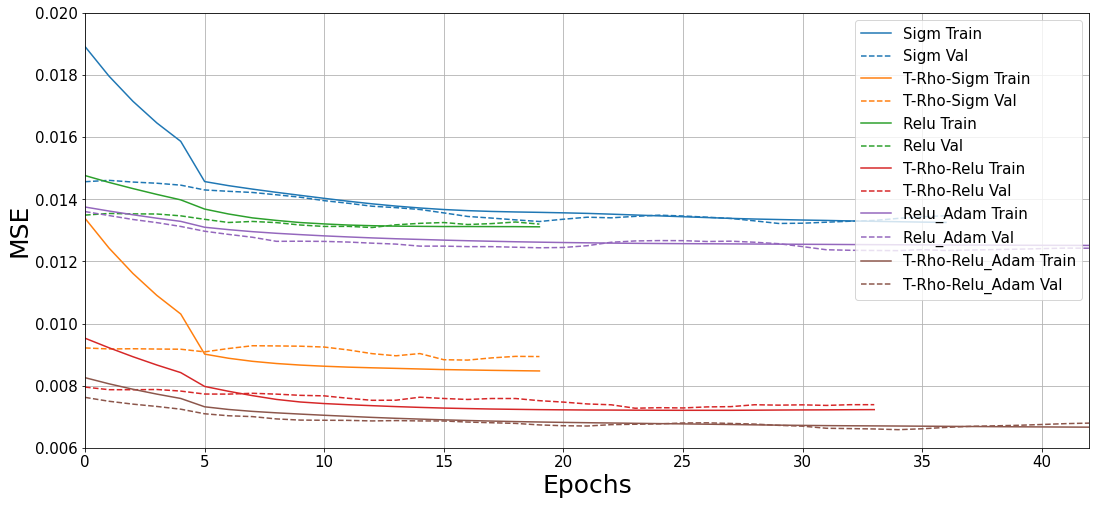

In [58]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.006, 0.02])
plt.ylabel('MSE')

In [59]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

240143/240143 - 6s - loss: 0.0129 - mae: 0.0774 - mse: 0.0129
Testing set for model 1, Mean Abs Error:    0.07736


In [60]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

240143/240143 - 6s - loss: 0.0082 - mae: 0.0517 - mse: 0.0082
Testing set for model 3, Mean Abs Error:              0.05170


In [61]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

240143/240143 - 6s - loss: 0.0126 - mae: 0.0745 - mse: 0.0126
Testing set for model 4, Mean Abs Error:              0.07445


In [62]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

240143/240143 - 5s - loss: 0.0068 - mae: 0.0450 - mse: 0.0068
Testing set for model 5, Mean Abs Error:              0.04499


In [63]:
loss6, mae6, mse6 = model6.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 6, Mean Abs Error: {:20.5f}".format(mae6))

240143/240143 - 6s - loss: 0.0123 - mae: 0.0734 - mse: 0.0123
Testing set for model 6, Mean Abs Error:              0.07341


In [64]:
loss7, mae7, mse7 = model7.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 7, Mean Abs Error: {:20.5f}".format(mae7))

240143/240143 - 6s - loss: 0.0065 - mae: 0.0452 - mse: 0.0065
Testing set for model 7, Mean Abs Error:              0.04523


In [65]:
mae = [ mae1, mae3, mae4, mae5, mae6, mae7 ]
mae

[0.077363916, 0.051704224, 0.07445485, 0.04499344, 0.07340685, 0.04523294]

In [66]:
mse = [ mse1, mse3, mse4, mse5, mse6, mse7 ]
mse

[0.012946513, 0.008200306, 0.012613652, 0.006844461, 0.012300782, 0.006468501]

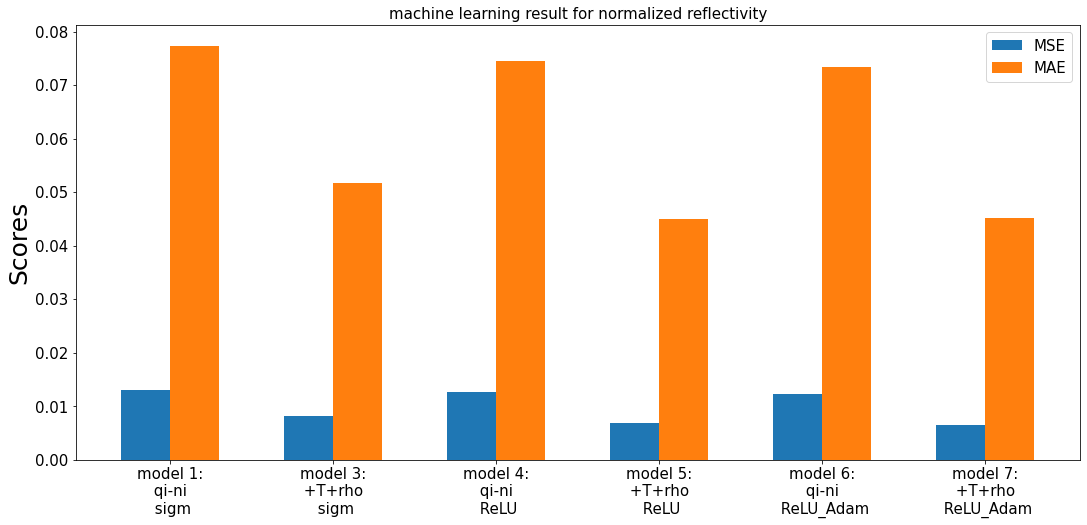

In [68]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1:\n qi-ni \n sigm',
 'model 3:\n +T+rho \n sigm',
 'model 4:\n qi-ni \n ReLU',
 'model 5:\n +T+rho \n ReLU',
 'model 6:\n qi-ni \n ReLU_Adam',
 'model 7:\n +T+rho \n ReLU_Adam' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized reflectivity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [69]:
test_true_z  = np.exp(test_labels.pop('z_s'))

In [70]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [71]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=["z_s"])

In [72]:
p1.describe()

z_s
count  240143.000000
mean        0.003593
std         0.994772
min        -4.859193
25%        -0.205702
50%         0.269036
75%         0.566166
max         2.373235

In [73]:
train_labels_stats

count       mean       std        min        25%        50%  \
z_s  1122035.0 -31.710714  2.655858 -46.041355 -32.262135 -31.028128   

           75%       max  
z_s -30.213095 -25.75177

In [74]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [75]:
test_predict1.describe()

z_s
count  2.401430e+05
mean   7.416773e-14
std    1.682738e-13
min    4.202432e-20
25%    9.793767e-15
50%    3.455604e-14
75%    7.607481e-14
max    9.237577e-12

In [76]:
test_predict1_z  = test_predict1['z_s']

In [77]:

p2 = pd.DataFrame(data=model4.predict(normed_test_data1), columns=["z_s"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_z = test_predict2['z_s']

In [78]:

p3 = pd.DataFrame(data=model6.predict(normed_test_data1), columns=["z_s"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_z = test_predict3['z_s']

### Maybe the ordering of the arrays is different? 

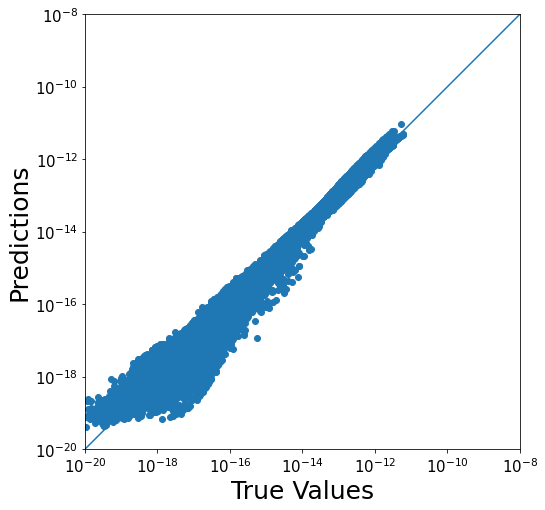

In [79]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-20, 1e-8

a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict1_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

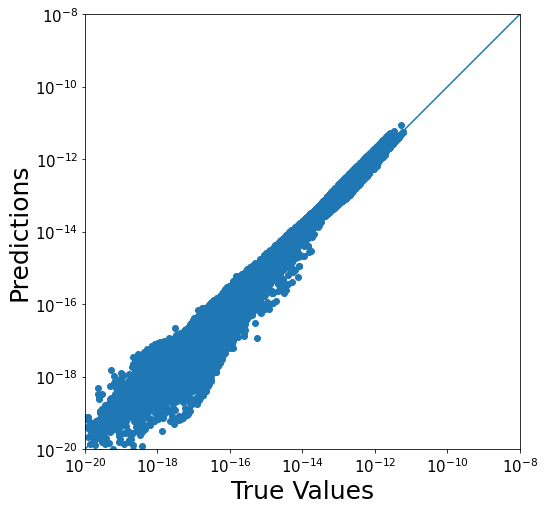

In [80]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict2_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

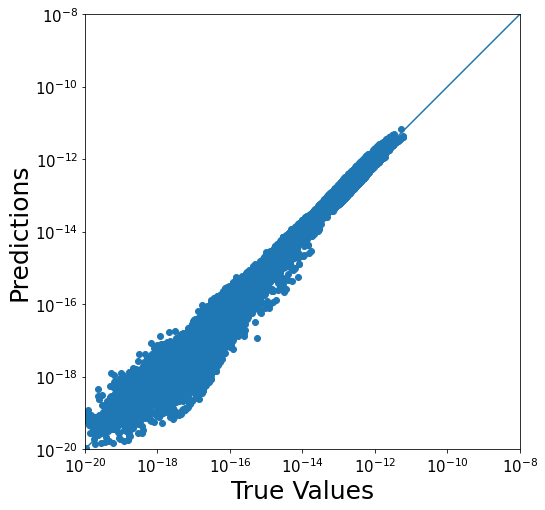

In [81]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict3_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [82]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [83]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [84]:
features = 'q_ice, n_ice'
labels   = 'z_ice'
logtransform = np.array([True, True], dtype=bool)
save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/refl_ice_model1_'+version+'.nc')
save2netcdf(model4,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/refl_ice_model4_'+version+'.nc')
save2netcdf(model6,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/refl_ice_model6_'+version+'.nc')

Saving model to saved_model_v2/refl_ice_model1_04.nc
  Features:   q_ice, n_ice
  Labels:     z_ice
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (2, 16), Activation: sigmoid
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/refl_ice_model4_04.nc
  Features:   q_ice, n_ice
  Labels:     z_ice
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (2, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/refl_ice_model6_04.nc
  Features

In [85]:
features = 'q_ice, n_ice, T, rho'
logtransform = np.array([True, True, False, False], dtype=bool)
save2netcdf(model3,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/refl_ice_model3_'+version+'.nc')
save2netcdf(model5,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/refl_ice_model5_'+version+'.nc')
save2netcdf(model7,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/refl_ice_model7_'+version+'.nc')

Saving model to saved_model_v2/refl_ice_model3_04.nc
  Features:   q_ice, n_ice, T, rho
  Labels:     z_ice
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: sigmoid
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/refl_ice_model5_04.nc
  Features:   q_ice, n_ice, T, rho
  Labels:     z_ice
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/refl_ice_model7_